#1. Import libraries

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import sklearn
from sklearn import metrics
from collections import  Counter
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#2. Load data from google drive

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
# file_id = '1wiizfhNmgDXzqPS8JaHo_wiBnIupQDZk'
# file_id = '1BAXRqlIE47WOjsQ7TFihasSPsbXf08sF'
file_id = '1cl0ZCe_ECxAy5tBricq3ZFsRcrqLN8ce'
drive_file = drive.CreateFile({'id': file_id})
drive_file.GetContentFile('credit_data.csv')
data = pd.read_csv('credit_data.csv')
data.head(10)

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_1_-2,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,...,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,Sex_1,Sex_2,Education_0,Education_1,Education_2,Education_3,Education_4,Education_5,Education_6,Marriage_0,Marriage_1,Marriage_2,Marriage_3,AgeBin_1,AgeBin_2,AgeBin_3,AgeBin_4,AgeBin_5,AgeBin_6,default.payment.next.month
0,-0.148974,-0.041864,-0.043729,-0.025434,-0.040753,-0.039971,-0.029872,-0.006483,-0.003107,-0.005832,-0.007771,-0.011252,-0.009865,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1,-0.047964,-0.042953,-0.045035,-0.024340,-0.037671,-0.036546,-0.027366,-0.006483,-0.002922,-0.004716,-0.006161,-0.011252,-0.006082,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
2,-0.078267,-0.019454,-0.033360,-0.018368,-0.027254,-0.025150,-0.017923,-0.004746,-0.002625,-0.004716,-0.006161,-0.008908,-0.000408,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,-0.118671,-0.003746,-0.000898,0.001251,-0.014082,-0.011257,-0.007166,-0.004194,-0.002317,-0.004493,-0.006000,-0.008746,-0.007974,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,-0.118671,-0.037702,-0.041291,-0.006137,-0.021028,-0.020987,-0.015170,-0.004194,0.018263,0.005328,0.006721,-0.009637,-0.008581,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,-0.118671,0.011660,0.007488,0.005817,-0.022484,-0.020518,-0.014484,-0.003622,-0.002438,-0.005099,-0.006161,-0.008908,-0.008352,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
6,0.335874,0.280280,0.344350,0.218515,0.470419,0.438958,0.334345,0.056478,0.020234,0.036577,0.024820,0.020985,0.016181,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
7,-0.068166,-0.034818,-0.046312,-0.025482,-0.040545,-0.040129,-0.029437,-0.006048,-0.003159,-0.005832,-0.006836,-0.007297,-0.006949,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
8,-0.027762,-0.035341,-0.033295,-0.019164,-0.029251,-0.028278,-0.027014,-0.002673,-0.003516,-0.005350,-0.006161,-0.008908,-0.007974,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
9,-0.148974,-0.045327,-0.046672,-0.025812,-0.040753,-0.027074,-0.019181,-0.006483,-0.003516,-0.005832,0.013174,-0.008622,-0.009865,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0


#3. Prepare data

In [ ]:
def data_prepare(data):
  x_data = data.loc[:, data.columns != 'default.payment.next.month']
  y_data = (data.iloc[:,-1].values)
  x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state=42)

  sm = SMOTE(random_state=589)
  x_SMOTE_train, y_SMOTE_train = sm.fit_sample(x_train, y_train)
  
  return x_SMOTE_train, y_SMOTE_train, x_test, y_test, x_train, y_train


In [ ]:
x_SMOTE_train, y_SMOTE_train, x_test, y_test, x_train, y_train = data_prepare(data)
print('y_label before SMOTE: ', Counter(y_train))
print('y_label after SMOTE: ', Counter(y_SMOTE_train))
print('train data x shape: ', x_SMOTE_train.shape)
print('train data y shape: ', y_SMOTE_train.shape)
print('test data x shape: ', x_test.shape)
print('test data y shape: ', y_test.shape)

y_label before SMOTE:  Counter({0: 18677, 1: 5323})
y_label after SMOTE:  Counter({0: 18677, 1: 18677})
train data x shape:  (37354, 96)
train data y shape:  (37354,)
test data x shape:  (6000, 96)
test data y shape:  (6000,)


#4. Build model
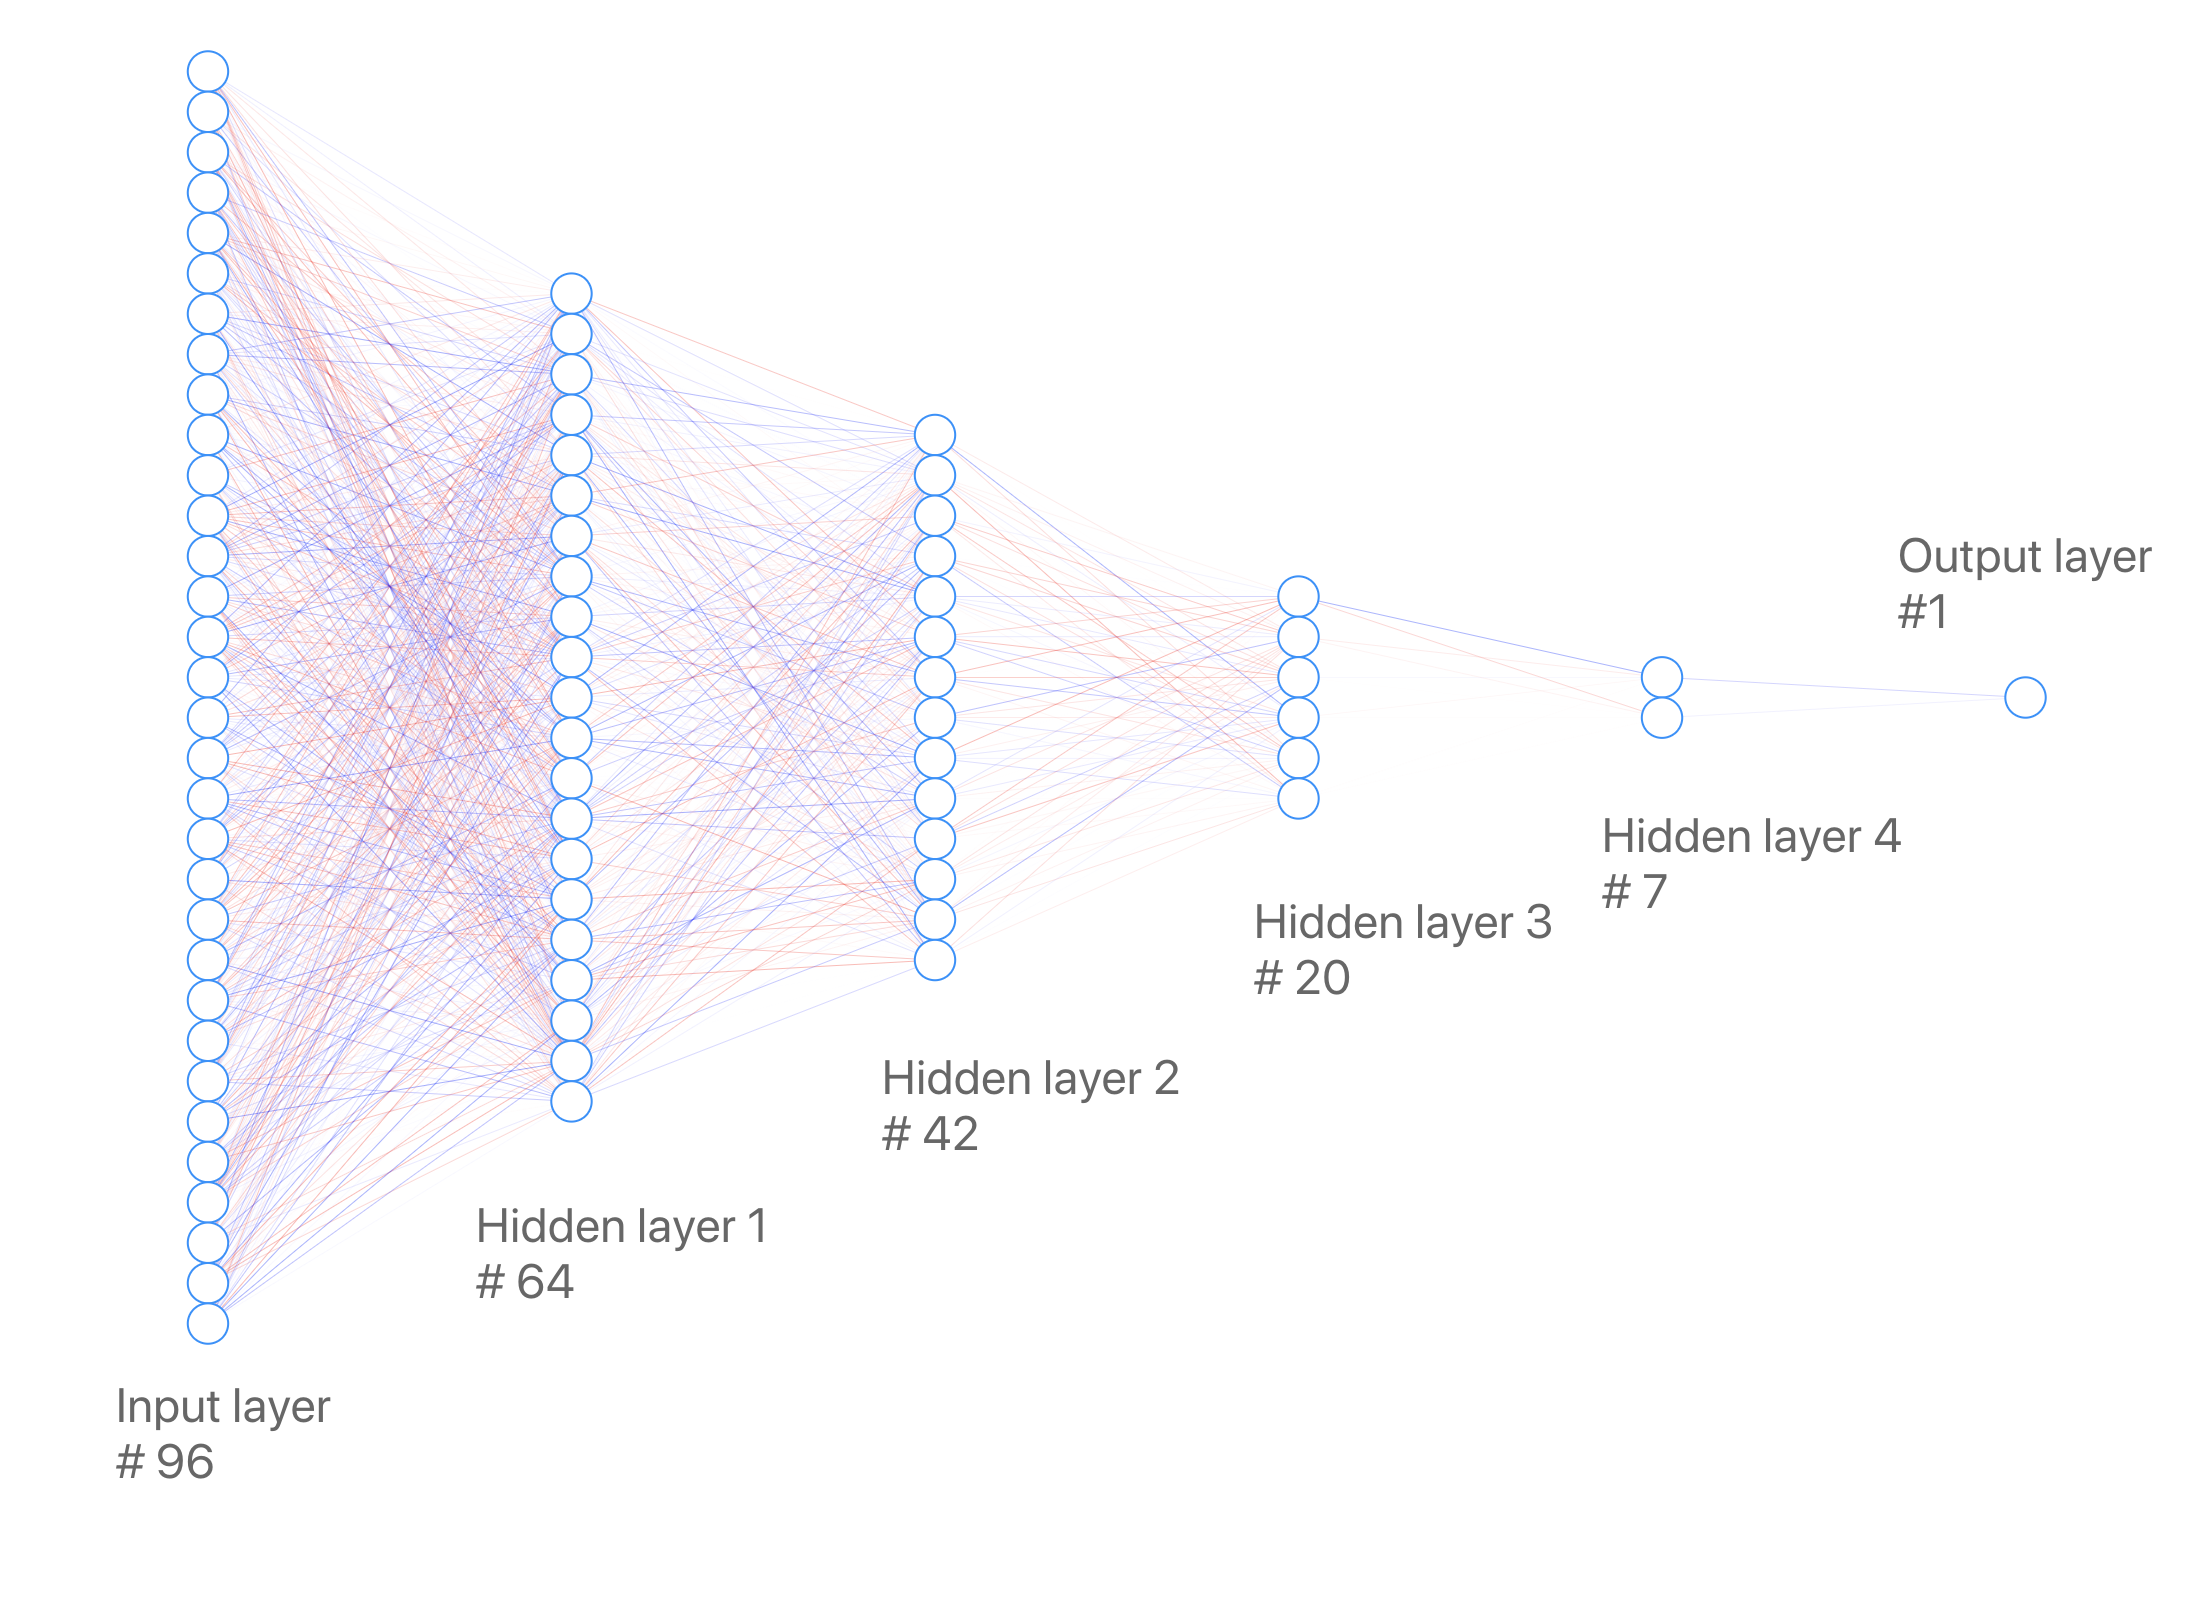

In [ ]:
def dnn_model():
  inputs = tf.keras.Input(shape = 96)
  x = layers.Dense(64, 
                   activation='relu', 
                   kernel_regularizer=regularizers.l2(0.002))(inputs)

  x = layers.Dense(42, 
                   activation='relu', 
                   kernel_regularizer=regularizers.l2(0.002))(x) #42

  x = layers.Dense(20, 
                   activation='relu', 
                   kernel_regularizer=regularizers.l2(0.002))(x) #20

  x = layers.Dense(7, 
                   activation='relu', 
                   kernel_regularizer=regularizers.l2(0.002))(x) #7

  outputs = layers.Dense(1, 
                         activation='sigmoid')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

#5. Train & evaluate the model

5.1 Train model

In [ ]:
model = dnn_model()
model.summary()

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
    metrics='accuracy'
)
model.fit(x_SMOTE_train, y_SMOTE_train, batch_size=256, epochs=300)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6208      
_________________________________________________________________
dense_1 (Dense)              (None, 42)                2730      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                860       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 8         
Total params: 9,953
Trainable params: 9,953
Non-trainable params: 0
____________________________________________________

5.2 Test model

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)

188/188 - 0s - loss: 0.5210 - accuracy: 0.7972


5.3 Save trained model

In [ ]:
model.save('dnn_model/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: dnn_model/assets


5.4 Load model and train on new dataset

In [ ]:
model = keras.models.load_model('dnn_model/')
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
    metrics='accuracy'
)
model.fit(x_SMOTE_train, y_SMOTE_train, batch_size=256, epochs=200)
model.evaluate(x_SMOTE_train, y_SMOTE_train)
loss, acc = model.evaluate(x_test, y_test, verbose=2)

Epoch 1/200
146/146 [==============================] - 0s 2ms/step - loss: 0.5880 - accuracy: 0.6990
Epoch 2/200
146/146 [==============================] - 0s 2ms/step - loss: 0.5861 - accuracy: 0.7025
Epoch 3/200
146/146 [==============================] - 0s 2ms/step - loss: 0.5841 - accuracy: 0.7016
Epoch 4/200
146/146 [==============================] - 0s 2ms/step - loss: 0.5857 - accuracy: 0.7016
Epoch 5/200
146/146 [==============================] - 0s 2ms/step - loss: 0.5869 - accuracy: 0.7002
Epoch 6/200
146/146 [==============================] - 0s 2ms/step - loss: 0.5855 - accuracy: 0.7013
Epoch 7/200
146/146 [==============================] - 0s 2ms/step - loss: 0.5858 - accuracy: 0.7024
Epoch 8/200
146/146 [==============================] - 0s 2ms/step - loss: 0.5870 - accuracy: 0.7019
Epoch 9/200
146/146 [==============================] - 0s 2ms/step - loss: 0.5846 - accuracy: 0.7013
Epoch 10/200
146/146 [==============================] - 0s 2ms/step - loss: 0.5864 - accura

5.5 Evaluate model

In [ ]:

predictions = model.predict(x_test)

for i in range(predictions.shape[0]):
  if predictions[i] > 0.5:  #Threshold value
    predictions[i] = 1
  else : predictions[i] = 0

# confusion_matrix = metrics.confusion_matrix(y_test, predictions)
# tn, fp, fn, tp = confusion_matrix.ravel()
# print(tp/(tp+fn))
# print('recall rate: ' + str(metrics.recall_score(y_test, predictions)))
# print(confusion_matrix)
loss, acc = model.evaluate(x_test, y_test, verbose=2)

188/188 - 0s - loss: 0.5245 - accuracy: 0.7902


In [ ]:
model.save('dnn_model/')

INFO:tensorflow:Assets written to: dnn_model/assets


DNN Confusion matrix:


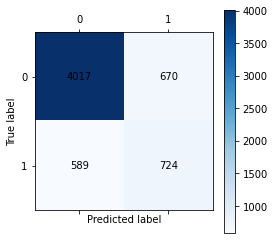

In [ ]:
def cm_plot(y,yp):
    
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y,yp)

    import matplotlib.pyplot as plt
    
    plt.matshow(cm,cmap=plt.cm.Blues)

    plt.colorbar()

    for x in range(len(cm)):
       for y in range(len(cm)):
          plt.annotate(cm[y,x],xy=(x,y),horizontalalignment='center',verticalalignment='center')
          plt.ylabel('True label')
          plt.xlabel('Predicted label')
    return plt
print('DNN Confusion matrix:')
cm_plot(y_test, predictions).show()
